In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from channel_hydraulics import *
from matplotlib.animation import FuncAnimation

NORMAL DEPTH [0.001]: Optimization terminated successfully
NORMAL DEPTH [0.01]: Iteration limit reached
FLOW DEPTH: Optimization terminated successfully


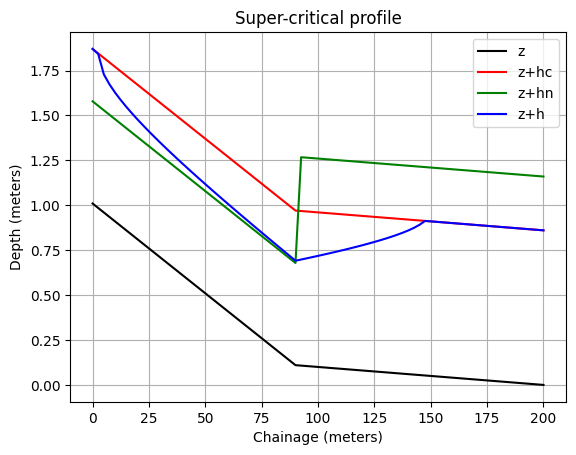

In [2]:

length_of_channel = 200
del_X = 2.5
ds_elev = 0
slope_breaks = [200,90, 0] #ds to us
long_slopes = [ 0.001,0.01]  #ds to us
Q = 50 #cu.m/s
d50 = 0.001 #characteriistic sediment diameter in m
boundary = np.array(['default'])
critical_shields_parameter = 0.033 #Tc from graph 

supercritical = BackwaterAnalysis(length_of_channel = length_of_channel, 
                    del_X= del_X,
                    ds_elev=ds_elev,
                    slope_breaks=slope_breaks,
                    long_slopes=long_slopes,
                    Q=Q,
                    d50=d50,
                    width=20,
                    hzslope=0,
                    boundary=boundary,
                    initial_depth= 0.7,
                    subcritical=False)

supercritical_depth = supercritical.depth_solver(max_iter=300)
supercritical_momentum = supercritical.momentum_solver(supercritical_depth)
supercritical.display_plot(values=supercritical_depth)





NORMAL DEPTH [0.001]: Optimization terminated successfully
NORMAL DEPTH [0.01]: Iteration limit reached
FLOW DEPTH: Optimization terminated successfully


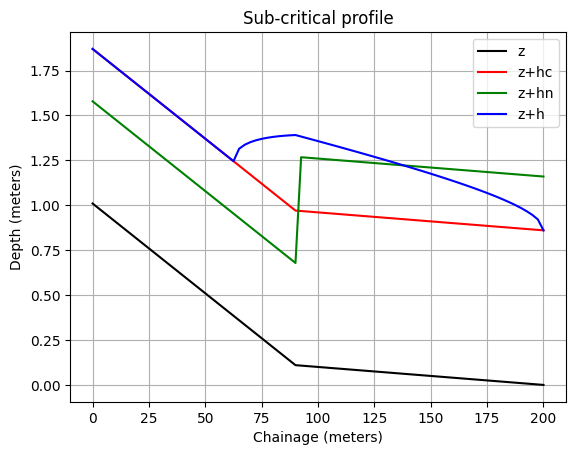

In [3]:
subcritical = BackwaterAnalysis(length_of_channel = length_of_channel, 
                    del_X= del_X,
                    ds_elev=ds_elev,
                    slope_breaks=slope_breaks,
                    long_slopes=long_slopes,
                    Q=Q,
                    d50=d50,
                    width=20,
                    hzslope=0,
                    boundary=boundary,
                    initial_depth= 1,
                    subcritical=True)

subcritical_depth = subcritical.depth_solver(max_iter=300)
subcritical_momentum = supercritical.momentum_solver(subcritical_depth)
subcritical.display_plot(values=subcritical_depth)

In [4]:
final_depth = np.where(supercritical_momentum>subcritical_momentum, supercritical_depth, subcritical_depth)

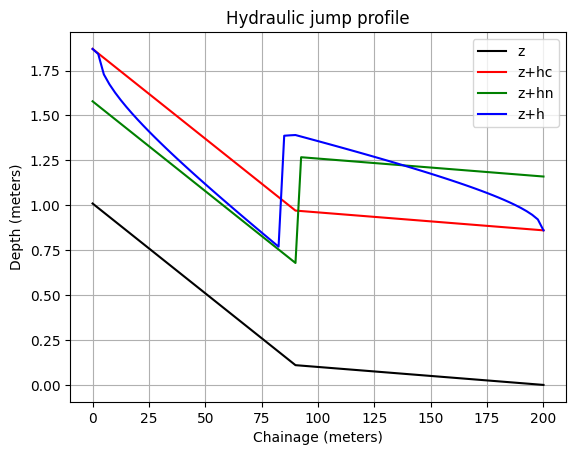

In [5]:
subcritical.display_plot(final_depth,combined=True)

Text(0, 0.5, 'Bed shear (N/m2)')

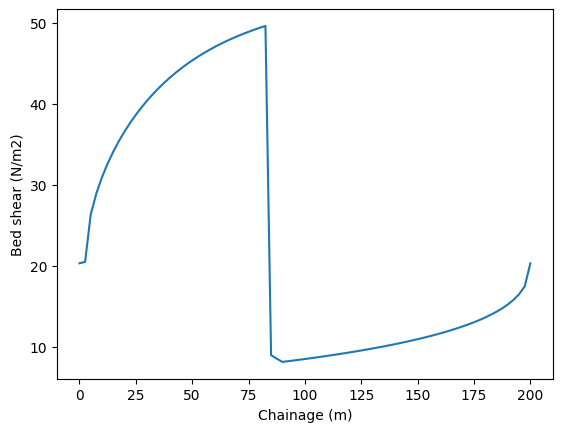

In [6]:
bed_shear = subcritical.bed_shear_stress(final_depth)
long_grids = make_grid(length_of_channel= length_of_channel,del_X=del_X)
plt.plot(long_grids,bed_shear)
plt.xlabel("Chainage (m)")
plt.ylabel("Bed shear (N/m2)")

In [7]:
shields_parameter_bed = subcritical.shields_parameter(bed_shear=bed_shear)
q_ein = subcritical.Einstein_parameter(shields_parameter=shields_parameter_bed)
qs = subcritical.sediment_transport_rate(q_star=q_ein)

shear_velocity = pow(bed_shear/1000,0.5)
max_velocity = max(shear_velocity)
del_T = math.floor(del_X/max_velocity)
del_T

11

In [10]:
# To solve Exner 1D equation

# Dictionary to keep track of different variables
bed_elevation_history = {0:subcritical.bed_elevation}
flow_depth_history = {0: final_depth}
del_T_history = []
bed_shear_history = {0: bed_shear}
sediment_transport_history = {0: qs}
zo = subcritical.bed_elevation
timestep = 20

for n in range(timestep):
    zo = Exner1D(long_grids=long_grids,del_T=del_T,del_X=del_X,qs= qs,zo= zo)
    updated_subcritical_depth = subcritical.depth_solver(max_iter=300,updated_bed_elevation=zo,exner=True)
    updated_subcritical_momentum = subcritical.momentum_solver(updated_subcritical_depth)
    updated_supercritical_depth = supercritical.depth_solver(max_iter=300,updated_bed_elevation=zo,exner=True)
    updated_supercritical_momentum = supercritical.momentum_solver(updated_supercritical_depth)
    updated_final_depth = np.where(updated_supercritical_momentum>updated_subcritical_momentum,updated_supercritical_depth,updated_subcritical_depth)
    updated_bed_shear = subcritical.bed_shear_stress(updated_final_depth)
    updated_shields_parameter = subcritical.shields_parameter(updated_bed_shear)
    updated_q_ein = subcritical.Einstein_parameter(shields_parameter=updated_shields_parameter)
    qs = subcritical.sediment_transport_rate(q_star=updated_q_ein)
    
    shear_velocity = pow(updated_bed_shear/1000,0.5)
    max_velocity = max(shear_velocity)
    del_T = math.floor(del_X/max_velocity)
    if del_T >= 30:
        del_T = 30
    bed_elevation_history[n+1] = zo
    flow_depth_history[n+1] = updated_final_depth
    del_T_history.append(del_T)
    bed_shear_history[n+1] = updated_bed_shear
    sediment_transport_history[n+1] = qs
    


FLOW DEPTH: Optimization terminated successfully
FLOW DEPTH: Optimization terminated successfully
FLOW DEPTH: Optimization terminated successfully
FLOW DEPTH: Optimization terminated successfully
FLOW DEPTH: Optimization terminated successfully
FLOW DEPTH: Optimization terminated successfully
FLOW DEPTH: Optimization terminated successfully


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


FLOW DEPTH: Optimization terminated successfully
FLOW DEPTH: Optimization terminated successfully
FLOW DEPTH: Optimization terminated successfully
FLOW DEPTH: Optimization terminated successfully
FLOW DEPTH: Optimization terminated successfully
FLOW DEPTH: Optimization terminated successfully
FLOW DEPTH: Optimization terminated successfully
FLOW DEPTH: Optimization terminated successfully
FLOW DEPTH: Optimization terminated successfully
FLOW DEPTH: Optimization terminated successfully
FLOW DEPTH: Optimization terminated successfully
FLOW DEPTH: Optimization terminated successfully
FLOW DEPTH: Optimization terminated successfully
FLOW DEPTH: Optimization terminated successfully
FLOW DEPTH: Optimization terminated successfully
FLOW DEPTH: Optimization terminated successfully
FLOW DEPTH: Optimization terminated successfully
FLOW DEPTH: Optimization terminated successfully
FLOW DEPTH: Optimization terminated successfully
FLOW DEPTH: Optimization terminated successfully
FLOW DEPTH: Optimiza

MovieWriter ffmpeg unavailable; using Pillow instead.


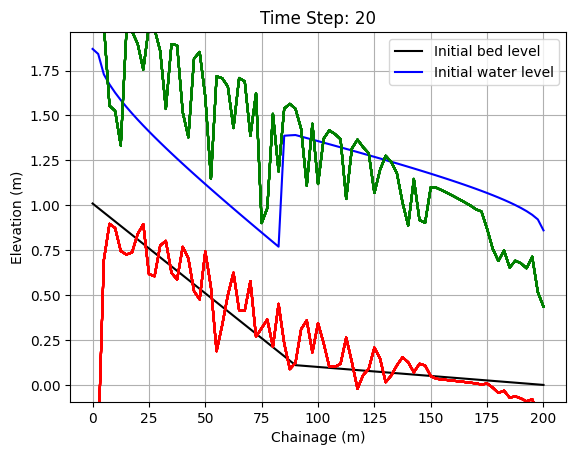

In [9]:
long_grids = make_grid(length_of_channel= length_of_channel,del_X=del_X)
fig, ax = plt.subplots()
#lines = [ax.plot(long_grids, bed_elevation_history[0])[0] for _ in range(len(long_grids)+1)]
lines_bed = [ax.plot(long_grids, bed_elevation_history[0], 
                     color = 'black',label='Initial bed level' if i ==0 else None)[0] for i in range(timestep+1)]
lines_flow_depth = [ax.plot(long_grids,flow_depth_history[0]+bed_elevation_history[0],
                            color = 'blue',label = "Initial water level" if i ==0 else None)[0] for i in range(timestep+1)]
#lines = ax.plot(long_grids, bed_elevation_history[0])
ax.set_title("Bed Elevation vs. Position")
ax.set_xlabel("Chainage (m)")
ax.set_ylabel("Elevation (m)")
ax.legend()
ax.grid()

def update(frame):
    time_step = sorted(bed_elevation_history.keys())[frame]
    bed_elevations = bed_elevation_history[time_step]
    flow_depth = flow_depth_history[time_step]

    for i in range(timestep): 
        lines_bed[i+1].set_ydata(bed_elevations)
        lines_bed[i+1].set_color('red')
        lines_bed[i+1].set_label(f"Bed")
        lines_flow_depth[i+1].set_ydata(flow_depth + bed_elevations)
        lines_flow_depth[i+1].set_color('green')

    ax.set_title(f"Time Step: {time_step}")

    return lines_bed

# Create the animation
ani = FuncAnimation(fig, update, frames=len(bed_elevation_history), repeat=False, blit=True)
ani.save('ElevationChanges_criticalboundary05.gif',fps = 1)
